# Deliverable 2: Scrape and Analyze Mars Weather Data

## Importing the dependencies

In [1]:
# Importing the dependencies
from bs4 import BeautifulSoup
from splinter import Browser
from webdriver_manager.chrome import ChromeDriverManager
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)

## Loading the webpage and creating BeautifulSoup object

In [3]:
# URL of page to be scraped
url = 'https://data-class-mars-challenge.s3.amazonaws.com/Mars/index.html'

# Retrieve page with the browser
browser.visit(url)
html = browser.html

# Create BeautifulSoup object; parse with 'html.parser'
soup = BeautifulSoup(html, 'html.parser')

In [4]:
# Extract title text
title = soup.title.text
print(title)

Mars Temperature Data


## 1) Scraping the data table into a Pandas DataFrame

After inspecting the page by using Chrome DevTools, the following information can be identified:
* **Table:** identified under `<table class="table">`
* **Table Header:** identified under `<th>`
* **Row:** identified under `<tr class="data-row">`

In [5]:
# Retrieve the table from the HTML page
table = soup.find('table', class_='table')

In [6]:
# Identify the table header to extract the column names
table_header = table.find_all('th')

columns = []
for column in table_header:
    columns.append(column.text)
    
columns

['id', 'terrestrial_date', 'sol', 'ls', 'month', 'min_temp', 'pressure']

In [7]:
# Creating the Pandas DataFrame to store the data extracted from HTML page
mars_temperature_df = pd.DataFrame(columns = columns)
mars_temperature_df

,id,terrestrial_date,sol,ls,month,min_temp,pressure


In [8]:
# Extracting the data for each row in the table
# Appending the row data into the Pandas DataFrame
for row in table.find_all('tr',class_='data-row'):
    # Retrieves all the columns (<td>) for the given row
    data = row.find_all('td')
    
    # Getting the text value for each column in the given row, and it is assigned to a list of values
    row_data=[td.text for td in data]
    
    # Appending the row data (list of values) in the end of the Pandas DataFrame
    mars_temperature_df.loc[len(mars_temperature_df)]=row_data

# Printing the Pandas DataFrame head
mars_temperature_df.head()

,id,terrestrial_date,sol,ls,month,min_temp,pressure
0,2,2012-08-16,10,155,6,-75.0,739.0
1,13,2012-08-17,11,156,6,-76.0,740.0
2,24,2012-08-18,12,156,6,-76.0,741.0
3,35,2012-08-19,13,157,6,-74.0,732.0
4,46,2012-08-20,14,157,6,-74.0,740.0


In [9]:
# Closing the browser session with Splinter
browser.quit()

## 2) Examine and convert the data types associated with each column as appropriate

Columns should have appropriate `datetime`, `int`, or `float` data types.

In [10]:
# Step 1: Examine the data types
mars_temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1867 entries, 0 to 1866
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1867 non-null   object
 1   terrestrial_date  1867 non-null   object
 2   sol               1867 non-null   object
 3   ls                1867 non-null   object
 4   month             1867 non-null   object
 5   min_temp          1867 non-null   object
 6   pressure          1867 non-null   object
dtypes: object(7)
memory usage: 116.7+ KB


In [11]:
# Step 2: Change the data types

# Changing appropriate columns to 'int'
mars_temperature_df[['id', 'sol', 'ls', 'month']] = mars_temperature_df[['id', 'sol', 'ls', 'month']].astype(int)

# Changing appropriate columns to 'float'
mars_temperature_df[['min_temp', 'pressure']] = mars_temperature_df[['min_temp', 'pressure']].astype(float)

# Changing appropriate column to 'datetime'
mars_temperature_df['terrestrial_date'] = pd.to_datetime(mars_temperature_df['terrestrial_date'])

In [12]:
# Step 3: Checking the data types
mars_temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1867 entries, 0 to 1866
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                1867 non-null   int32         
 1   terrestrial_date  1867 non-null   datetime64[ns]
 2   sol               1867 non-null   int32         
 3   ls                1867 non-null   int32         
 4   month             1867 non-null   int32         
 5   min_temp          1867 non-null   float64       
 6   pressure          1867 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int32(4)
memory usage: 87.5 KB


## 3) Analyse the Dataset

Analyze your dataset by using Pandas functions to answer the following questions:

 1. How many months exist on Mars?
 2. How many Martian (and not Earth) days worth of data exist in the scraped dataset?
 3. What are the coldest and the warmest months on Mars (at the location of Curiosity)? To answer this question:
  * Find the average the minimum daily temperature for all of the months.
  * Plot the results as a bar chart.
 4. Which months have the lowest and the highest atmospheric pressure on Mars? To answer this question:
  * Find the average the daily atmospheric pressure of all the months.
  * Plot the results as a bar chart.
 5. About how many terrestrial (Earth) days exist in a Martian year? To answer this question:
  * Consider how many days elapse on Earth in the time that Mars circles the Sun once.
  * Visually estimate the result by plotting the daily minimum temperature.

### 3.1) How many months exist on Mars?

In [13]:
print(f'There are', mars_temperature_df['month'].nunique(), 'months on Mars.')

There are 12 months on Mars.


### 3.2) How many Martian (and not Earth) days worth of data exist in the scraped dataset?

In [14]:
# Calculating the unique days since Curiosity landed on Mars
unique_days = mars_temperature_df['sol'].nunique()

# Checking the first day and the last day that is available in the database
first_day = mars_temperature_df['sol'].min()
last_day = mars_temperature_df['sol'].max()

print(f'There are ', unique_days, ' Martian days in the dataset since Curiosity landed on Mars, from ', first_day, ' to ', last_day,'.')

There are  1867  Martian days in the dataset since Curiosity landed on Mars, from  10  to  1977 .


### 3.3) What are the coldest and the warmest months on Mars (at the location of Curiosity)?

In [15]:
# Creating a DataFrame only with the required columns
avg_min_temp = mars_temperature_df[['month', 'min_temp']]

# Grouping by month, calculating the average of the min_temp
avg_min_temp = avg_min_temp.groupby('month').mean()

In [16]:
# Presenting the average of the minimum daily temperature for all of the months
avg_min_temp

,min_temp
month,
1,-77.160920
2,-79.932584
3,-83.307292
4,-82.747423
5,-79.308725
6,-75.299320
7,-72.281690
8,-68.382979
9,-69.171642


Text(0, 0.5, 'Average Minimum Temperature')

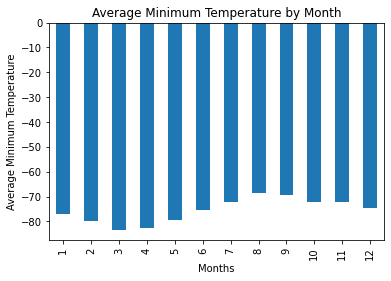

In [17]:
# Ploting the results as a bar chart.
avg_min_temp.plot(kind='bar', legend=False)

# Updating the Title and the Labels
plt.title('Average Minimum Temperature by Month')
plt.xlabel("Months")
plt.ylabel("Average Minimum Temperature")

### 3.4) Which months have the lowest and the highest atmospheric pressure on Mars?

In [18]:
# Creating a DataFrame only with the required columns
avg_pressure = mars_temperature_df[['month', 'pressure']]

# Grouping by month, calculating the average of the atmospheric pressure
avg_pressure = avg_pressure.groupby('month').mean()

In [19]:
# Presenting the average of the atmospheric pressure for all of the months
avg_pressure

,pressure
month,
1,862.488506
2,889.455056
3,877.322917
4,806.329897
5,748.557047
6,745.054422
7,795.105634
8,873.829787
9,913.305970


In [20]:
# Finding the monht with the lowest average of the atmospheric pressure
lowest_avg_pressure = avg_pressure.loc[avg_pressure['pressure'] == avg_pressure['pressure'].min()]
lowest_avg_pressure

,pressure
month,
6,745.054422


Month **6** presents the lowest average of athmosferic pressure.

In [21]:
# Finding the monht with the highest average of the atmospheric pressure
highest_avg_pressure = avg_pressure.loc[avg_pressure['pressure'] == avg_pressure['pressure'].max()]
highest_avg_pressure

,pressure
month,
9,913.30597


Month **9** presents the highest average of athmosferic pressure.

Text(0, 0.5, 'Average Athmosferic Pressure')

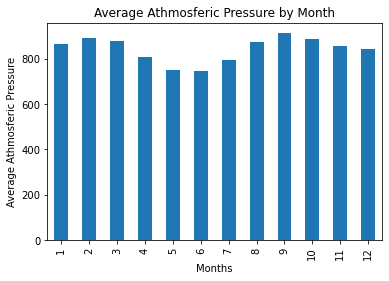

In [22]:
# Ploting the results as a bar chart.
avg_pressure.plot(kind='bar', legend=False)

# Updating the Title and the Labels
plt.title('Average Athmosferic Pressure by Month')
plt.xlabel("Months")
plt.ylabel("Average Athmosferic Pressure")

### 3.5) How many terrestrial (Earth) days exist in a Martian year?

In [23]:
# Consider how many days elapse on Earth in the time that Mars circles the Sun once
# Assuming the difference of 2 different terrestrial_date where the Mar's solar longitude are the same

# Listing the data where Mar's solar longitude is zero
mars_temperature_df.loc[mars_temperature_df['ls'] == 0]

,id,terrestrial_date,sol,ls,month,min_temp,pressure
304,320,2013-08-01,351,0,1,-75.0,853.0
305,319,2013-08-02,352,0,1,-77.0,854.0
925,954,2015-06-19,1019,0,1,-81.0,849.0
926,938,2015-06-20,1020,0,1,-63.0,832.0
1579,1606,2017-05-06,1688,0,1,-76.0,840.0
1580,1610,2017-05-07,1689,0,1,-75.0,840.0


In [24]:
# Calculating the number of days between sol=352 and sol=1019 (as per the query above):
date_1 = mars_temperature_df['terrestrial_date'].loc[mars_temperature_df['ls'] == 0].iloc[1]
date_2 = mars_temperature_df['terrestrial_date'].loc[mars_temperature_df['ls'] == 0].iloc[2]

In [25]:
days_martial_year = (date_2 - date_1)
print(f'A Martial year has aproximatelly ', days_martial_year, ' days.')

A Martial year has aproximatelly  686 days 00:00:00  days.


Text(0, 0.5, 'Minimum Temperature')

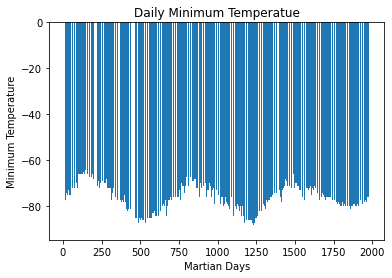

In [26]:
# Ploting the all the minimum temperatures since Curiosity landed on Mars.
plt.bar(mars_temperature_df['sol'], mars_temperature_df['min_temp'])

# Updating the Title and the Labels
plt.title('Daily Minimum Temperatue')
plt.xlabel("Martian Days")
plt.ylabel("Minimum Temperature")

## 4) Export the DataFrame to a CSV file

In [27]:
# Saving the Pandas DataFrame into a CSV file, assuming the folder 'output' has been already created
mars_temperature_df.to_csv('output/mars_min_temperature.csv', index=False)